In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Config Section
cfg_batch_size  = 20
cfg_max_epochs  = 200
cfg_num_workers = 2

# Array Building Config
cfg_array_count      = 1000
cfg_min_array_length = 10
cfg_max_array_length = 30
cfg_start_int = 1
cfg_stop_int = 2
cfg_empty_int = 0

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "OL5"
cfg_logger_version = "parity-transformer"

In [3]:
# Create The data and parity array
# Code it with start and stop integers
def make_arrays():
    # Generate a random length between 10 and 30 (30 + 1)
    length = np.random.randint(cfg_min_array_length, cfg_max_array_length + 1)

    # Create a random array of 0s and 1s with the random length
    data_array = np.random.randint(2, size=length)

    # Initialize an array to store the cumulative sum of random_array
    cumulative_sum = np.cumsum(data_array)

    # Calculate parity for each cumulative sum and save to a separate array
    parity_array = cumulative_sum % 2

    # No We need to convert Array to Encoding 0s = 3 and 1s = 4
    enc_data_array = np.where(data_array == 0, 3, 4)
    enc_parity_array = np.where(parity_array == 0, 3, 4)
    
    enc_data_array = np.concatenate(([cfg_start_int], enc_data_array, [cfg_stop_int]))
    enc_parity_array = np.concatenate(([cfg_start_int], enc_parity_array, [cfg_stop_int]))

    # Add Padding at the end to make sure ALL Arrays are same length
    enc_data_array = np.pad(enc_data_array, (0, cfg_max_array_length - length), 'constant')
    enc_parity_array = np.pad(enc_parity_array, (0, cfg_max_array_length - length), 'constant')

    return np.array([np.array(enc_data_array), np.array(enc_parity_array)])


# Create an array to store 1000 arrays generated by make_arrays
data = np.array([make_arrays() for _ in range(cfg_array_count)])
print(f"data.shape: {data.shape}")

# Print Example of First Row
data_array = data[0][0]
parity_array = data[0][1]
print("\nArray Example:")
print("Encoded:\nKey: 1 = Start, 2 = Stop, 3 = Zero, 4 = One, 0 = Padding / Empty")
print("Data Array:   ", data_array)
print("Parity Array: ", parity_array)
print("")


data.shape: (1000, 2, 32)

Array Example:
Encoded:
Key: 1 = Start, 2 = Stop, 3 = Zero, 4 = One, 0 = Padding / Empty
Data Array:    [1 3 3 3 4 4 3 3 3 4 3 3 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Parity Array:  [1 3 3 3 4 3 3 3 3 4 4 4 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



In [4]:
# Set Split Point
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
split_point

In [5]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [6]:
# Setup - Create X & Y
X = data[:,0]
Y = data[:,1]

enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train


array([[1, 3, 3, ..., 0, 0, 0],
       [1, 4, 4, ..., 0, 0, 0],
       [1, 4, 3, ..., 0, 0, 0],
       ...,
       [1, 3, 3, ..., 0, 0, 0],
       [1, 4, 3, ..., 0, 0, 0],
       [1, 4, 4, ..., 0, 0, 0]])

In [7]:
# Setup
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[1, 3, 3, ..., 0, 0, 0],
       [1, 4, 3, ..., 0, 0, 0],
       [1, 4, 4, ..., 0, 0, 0],
       ...,
       [1, 3, 3, ..., 2, 0, 0],
       [1, 4, 4, ..., 0, 0, 0],
       [1, 4, 3, ..., 0, 0, 0]])

In [8]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[3, 3, 3, ..., 0, 0, 0],
       [4, 3, 3, ..., 0, 0, 0],
       [4, 4, 3, ..., 0, 0, 0],
       ...,
       [3, 3, 4, ..., 0, 0, 0],
       [4, 4, 3, ..., 0, 0, 0],
       [4, 3, 4, ..., 0, 0, 0]])

In [9]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

print("----")

print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(800, 32)
(800, 31)
(800, 31)
----
(200, 32)
(200, 31)
(200, 31)


In [10]:
enc_x_train.shape[1:]

In [11]:
# Start, Stop, One, Zero, Empty
token_count = 5
print(f"Token Count: {token_count}")

enc_x_train.shape[-1]

Token Count: 5


In [12]:
class TransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads, 
                                               dropout=dropout,
                                               batch_first=True)
    
    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y, y, y)[0]
        x=y=x+y
        y = self.layer_norm2(y)
        y = self.linear(y)
        y = self.activation(y)
        return x +  y

class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 max_length,
                 latent_size = 64,
                 num_heads = 4,
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = torch.nn.Embedding(num_tokens,
                                                  latent_size,
                                                  padding_idx=0)
        self.position_embedding = torch.nn.Embedding(max_length+1,
                                                     latent_size,
                                                     padding_idx=0)
        self.transformer_blocks = torch.nn.Sequential(*[
            TransformerBlock(latent_size=latent_size,
                             num_heads=num_heads) for _ in range(n_layers)
        ])
        
    def forward(self, x):
        y = x
        y = self.token_embedding(y) + \
            self.position_embedding(torch.arange(1,y.shape[1]+1).long().to(device) * torch.sign(y).long().to(device))
        y = self.transformer_blocks(y)
        return y


In [13]:
enc_net = EncoderNetwork(num_tokens=token_count, max_length=enc_x_train.shape[-1])
summary(enc_net, input_size=enc_x_train[0:5].shape,dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 32, 64]               --
├─Embedding: 1-1                         [5, 32, 64]               320
├─Embedding: 1-2                         [5, 32, 64]               2,112
├─Sequential: 1-3                        [5, 32, 64]               --
│    └─TransformerBlock: 2-1             [5, 32, 64]               --
│    │    └─LayerNorm: 3-1               [5, 32, 64]               128
│    │    └─MultiheadAttention: 3-2      [5, 32, 64]               16,640
│    │    └─LayerNorm: 3-3               [5, 32, 64]               128
│    │    └─Linear: 3-4                  [5, 32, 64]               4,160
│    │    └─GELU: 3-5                    [5, 32, 64]               --
│    └─TransformerBlock: 2-2             [5, 32, 64]               --
│    │    └─LayerNorm: 3-6               [5, 32, 64]               128
│    │    └─MultiheadAttention: 3-7      [5, 32, 64]               16,6

In [14]:
enc_x_train[0:5].shape

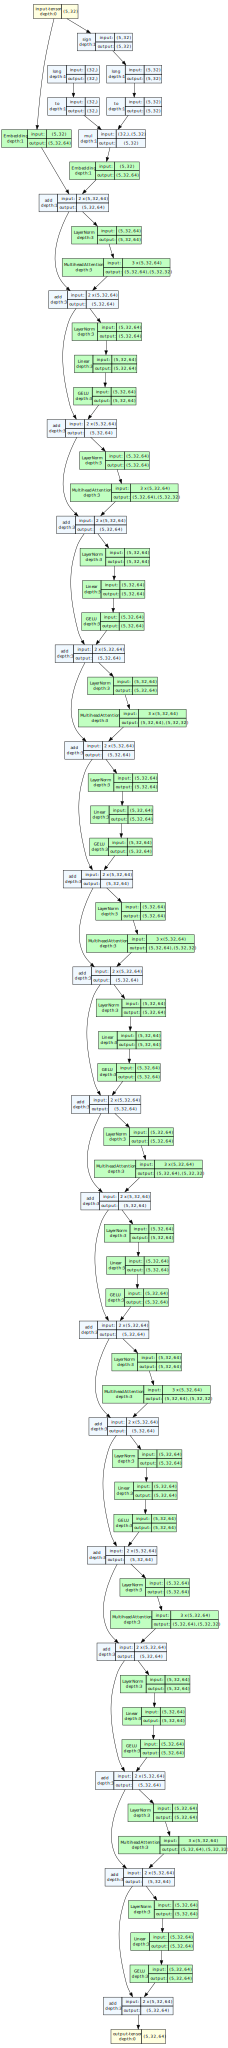

In [15]:
model_graph = draw_graph(enc_net,
                         input_data = torch.Tensor(enc_x_train[0:5]).long(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])
model_graph.visual_graph

In [16]:
class MaskedTransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64, 
                 num_heads = 4, 
                 dropout = 0.1, 
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size) 
        self.layer_norm2 = torch.nn.LayerNorm(latent_size) 
        self.layer_norm3 = torch.nn.LayerNorm(latent_size) 
        self.dropout = torch.nn.Dropout(dropout) 
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha1 = torch.nn.MultiheadAttention(latent_size,
                                                num_heads, 
                                                dropout=dropout, 
                                                batch_first=True)
        self.mha2 = torch.nn.MultiheadAttention(latent_size, 
                                                num_heads,
                                                dropout=dropout, 
                                                batch_first=True)
    
    def make_causal_mask(self, sz: int):
        return torch.triu(torch.full((sz, sz), True), diagonal=1).to(device) 
        # return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def forward(self, x):
        x_enc, x_dec = x
        x = y = x_dec
        y = self.layer_norm1(y)
        y = self.mha1(y,y,y,
                      attn_mask=self.make_causal_mask(y.shape[1]))[0]
        x = y = x + y
        y = self.layer_norm2(y)
        y = self.mha2(y, x_enc, x_enc)[0] 
        x = y = x + y
        y = self.layer_norm3(y)
        y = self.linear(y)
        y = self.activation(y)
        return x_enc, x + y


class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 max_length, 
                 latent_size = 64, 
                 num_heads = 4, 
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = torch.nn.Embedding(num_tokens,
                                                  latent_size,
                                                  padding_idx=0) 
        self.position_embedding = torch.nn.Embedding(max_length+1,
                                                     latent_size,
                                                     padding_idx=0) 
        self.transformer_blocks = torch.nn.Sequential(*[
            MaskedTransformerBlock(latent_size=latent_size,
                                   num_heads=num_heads) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)

    def forward(self, x_enc, x_dec):
        y = x_dec
        y = self.token_embedding(y) + \
        self.position_embedding(torch.arange(1,y.shape[1]+1).long().to(device) * torch.sign(y).long().to(device))
        y = self.transformer_blocks((x_enc,y))[1]
        y = self.output_layer(y)
        return y

In [17]:
enc_x_train[0:5].shape

In [18]:
dec_x_train[0:5].shape

In [19]:
# Passed through the encoder network - output tensor shape for decoder
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).shape

torch.Size([5, 32, 64])

In [20]:
dec_net = DecoderNetwork(num_tokens=token_count, max_length=dec_x_train.shape[-1])
summary(dec_net,input_size=[enc_x_train[0:5].shape[0:2]+(64,),dec_x_train[0:5].shape], dtypes=[torch.float32, torch.long])

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 31, 5]                --
├─Embedding: 1-1                         [5, 31, 64]               320
├─Embedding: 1-2                         [5, 31, 64]               2,048
├─Sequential: 1-3                        [5, 32, 64]               --
│    └─MaskedTransformerBlock: 2-1       [5, 32, 64]               --
│    │    └─LayerNorm: 3-1               [5, 31, 64]               128
│    │    └─MultiheadAttention: 3-2      [5, 31, 64]               16,640
│    │    └─LayerNorm: 3-3               [5, 31, 64]               128
│    │    └─MultiheadAttention: 3-4      [5, 31, 64]               16,640
│    │    └─LayerNorm: 3-5               [5, 31, 64]               128
│    │    └─Linear: 3-6                  [5, 31, 64]               4,160
│    │    └─GELU: 3-7                    [5, 31, 64]               --
│    └─MaskedTransformerBlock: 2-2       [5, 32, 64]               

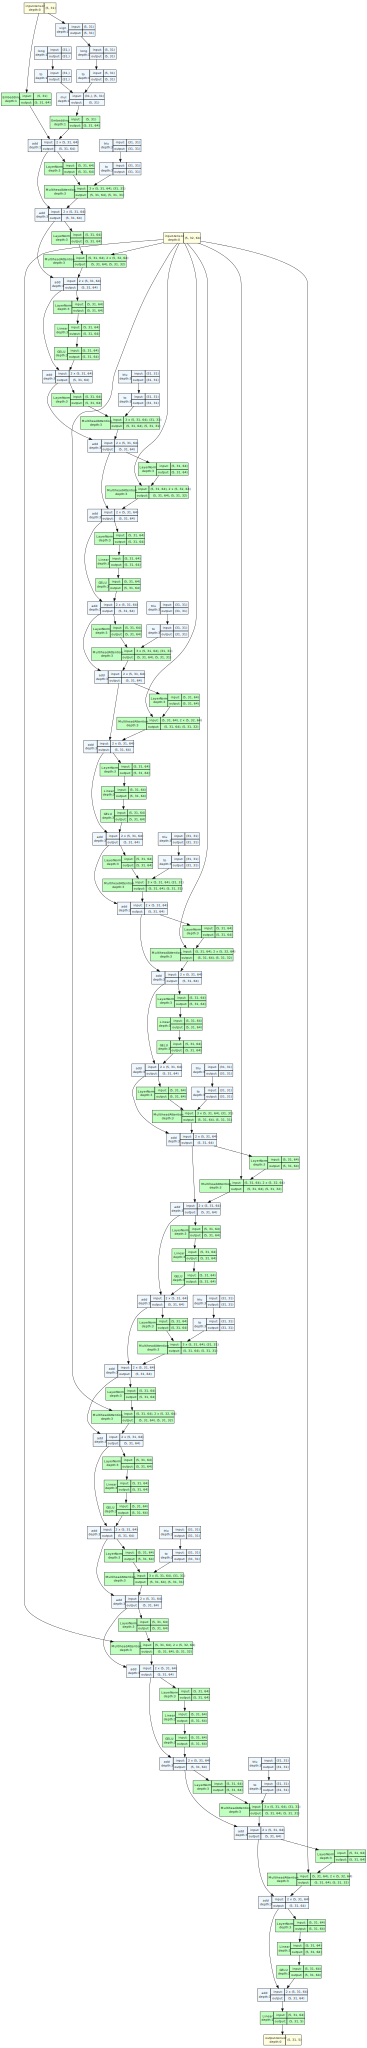

In [21]:
model_graph = draw_graph(dec_net,
                         input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)), torch.Tensor(dec_x_train[0:5]).long()],
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [22]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [23]:
class EncDecNetwork(EncDecLightningModule): 
    def __init__(self,
                 num_enc_tokens,
                 max_enc_length,
                 num_dec_tokens, 
                 max_dec_length, 
                 latent_size = 64,
                 num_heads = 4, 
                 n_layers = 8,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens, **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens, max_enc_length, latent_size, num_heads, n_layers) 
        self.dec_net = DecoderNetwork(num_dec_tokens, max_dec_length, latent_size, num_heads, n_layers)

    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)

In [24]:
enc_dec_net = EncDecNetwork(num_enc_tokens=token_count, 
                            max_enc_length=enc_x_train.shape[-1],
                            num_dec_tokens=token_count, 
                            max_dec_length=dec_x_train.shape[-1], 
                            latent_size=64,
                            n_layers=4)

summary(enc_dec_net, input_size=[enc_x_train[0:1].shape, 
                                 dec_x_train[0:1].shape], 
        dtypes=[torch.long, torch.long])

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                        Output Shape              Param #
EncDecNetwork                                 [1, 31, 5]                --
├─EncoderNetwork: 1-1                         [1, 32, 64]               --
│    └─Embedding: 2-1                         [1, 32, 64]               320
│    └─Embedding: 2-2                         [1, 32, 64]               2,112
│    └─Sequential: 2-3                        [1, 32, 64]               --
│    │    └─TransformerBlock: 3-1             [1, 32, 64]               21,056
│    │    └─TransformerBlock: 3-2             [1, 32, 64]               21,056
│    │    └─TransformerBlock: 3-3             [1, 32, 64]               21,056
│    │    └─TransformerBlock: 3-4             [1, 32, 64]               21,056
├─DecoderNetwork: 1-2                         [1, 31, 5]                --
│    └─Embedding: 2-4                         [1, 31, 64]               320
│    └─Embedding: 2-5                         [1, 31, 64]               2,

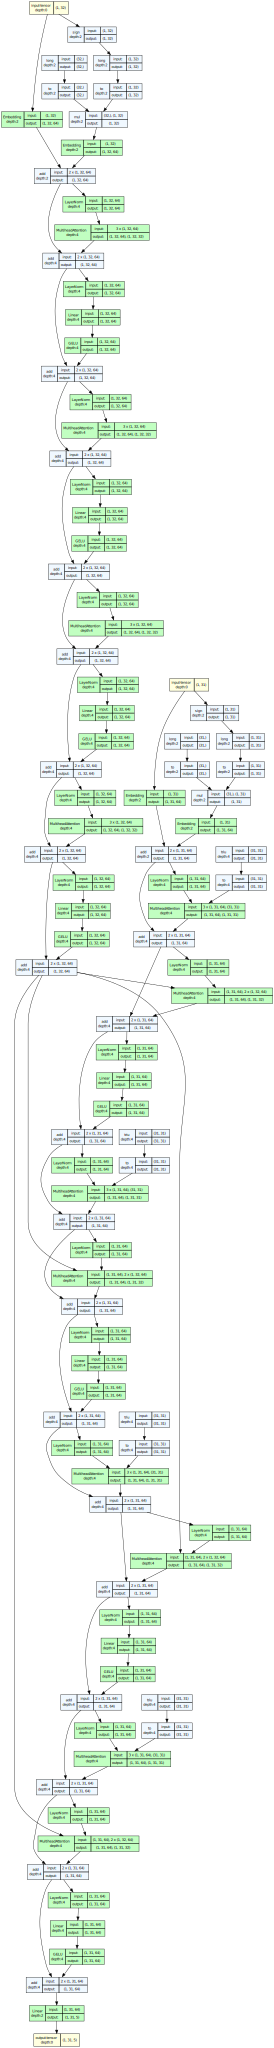

In [25]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()], 
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True, 
                         expand_nested=False, 
                         depth=4, 
                         dtypes=[torch.long])

model_graph.visual_graph

In [26]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(), 
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [27]:
logger = pl.loggers.CSVLogger(cfg_logger_dir,
                              name=cfg_logger_name,
                              version=cfg_logger_version)

In [28]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.validate(enc_dec_net, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/OL5/parity-transformer exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.2527082860469818     │
│         val_loss          │    1.7091354131698608     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.2527082860469818, 'val_loss': 1.7091354131698608}]

In [30]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.21000364422798157    │
│         test_loss         │    1.6964004039764404     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.21000364422798157, 'test_loss': 1.6964004039764404}]

In [31]:
trainer.fit(enc_dec_net, xy_train, xy_val) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 86.7 K
3 | dec_net  | DecoderNetwork     | 153 K 
------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.963     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [32]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,test_acc,test_loss,train_acc,train_loss
0,0.252708,1.709135,0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,0,0,0.210004,1.6964,NaN,NaN
2,0.538397,0.769821,0,39,NaN,NaN,NaN,NaN
3,NaN,NaN,0,39,NaN,NaN,0.494643,0.863615
4,0.619629,0.677300,1,79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
397,NaN,NaN,197,7919,NaN,NaN,0.999577,0.001418
398,1.000000,0.000019,198,7959,NaN,NaN,NaN,NaN
399,NaN,NaN,198,7959,NaN,NaN,0.999449,0.001783
400,1.000000,0.000010,199,7999,NaN,NaN,NaN,NaN


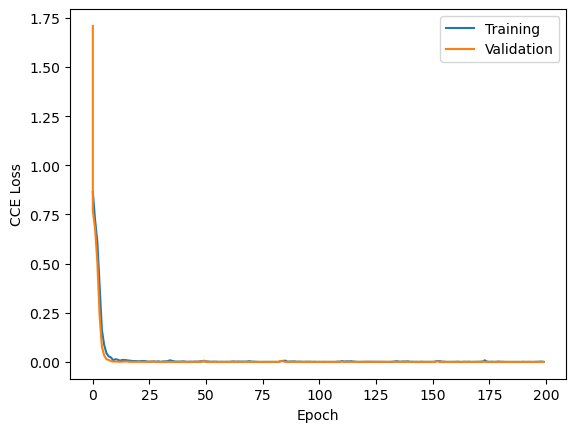

In [33]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("CCE Loss") 
plt.xlabel("Epoch") 
plt.show()

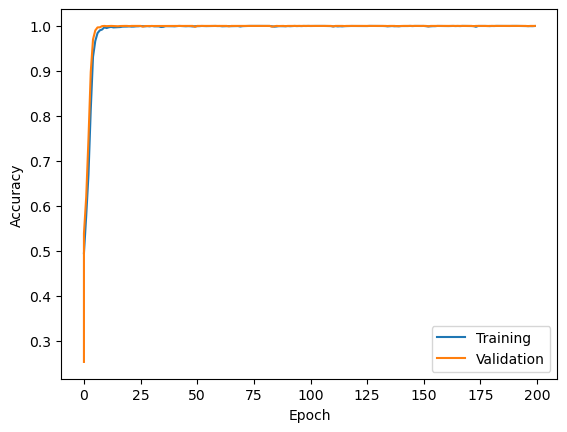

In [34]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))], 
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))], 
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))], 
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Accuracy")
plt.xlabel("Epoch") 
plt.show()

In [35]:
print("")
print("Validation accuracy:", *["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])
print("")
print("")


Validation accuracy: 0.25270829 0.53839701 0.61962897 0.74931550 0.89737993 0.97002202 0.98996854 0.99672782 0.99688613 0.99951208 1.00000000 0.99952370 0.99976522 1.00000000 0.99977273 0.99977273 0.99928212 0.99976522 1.00000000 1.00000000 1.00000000 0.99952370 1.00000000 1.00000000 1.00000000 0.99977064 1.00000000 0.99836624 0.99975848 0.99975848 1.00000000 1.00000000 1.00000000 0.99977064 1.00000000 0.99976522 0.99977064 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 0.99792218 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 0.99904746 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 0.99841154 0.99929643 1.00000000 0.99977273 1.00000000

In [36]:
# Test Model
results = trainer.test(enc_dec_net, xy_val)

print("")
print("Test Accuracy:", results[0]['test_acc'])
print("")
print("")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │  1.0354149708291516e-05   │
└───────────────────────────┴───────────────────────────┘


Test Accuracy: 1.0


